In [1]:
import os
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

from natsort import natsorted

from tifffile import imread

from skimage.color import gray2rgb
from skimage import img_as_float

In [2]:
core = '74'

In [3]:
save_dir = '/Users/greg/Dropbox (HMS)/Baker_QC_2021/script_output/dropout_gate'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# read EMIT22 single-cell data
data = pd.read_parquet('/Volumes/My Book/cylinter_input/emit22_full/output/checkpoints/aggregateData.parquet')

# isolate core data
core_data = data[data['Sample'] == core]

# isolate 'Sample' and Hoechst channel columns
dna_data = core_data[['Sample'] + [i for i in core_data.columns if 'DNA' in i]]

In [4]:
# save DNA image of each cycle
cycle_dir = os.path.join(save_dir, 'cycle_images')
if not os.path.exists(cycle_dir):
    os.makedirs(cycle_dir)

for e, dna in enumerate([0, 4, 8, 12, 16, 20, 24, 28, 32, 36]):

    fig, ax = plt.subplots()

    img = imread(
        f'/Volumes/My Book/cylinter_input/emit22_full/tif/{core}.ome.tif', key=dna
        )
    
    img = np.clip(img, 0, 8000) 
    
    plt.imshow(img, cmap='Greys')
    ax.axis('off')
    plt.tight_layout()
    plt.savefig(os.path.join(cycle_dir, f'dna_cycle{e+1}.png'), dpi=600)
    plt.show()
    plt.close('all')

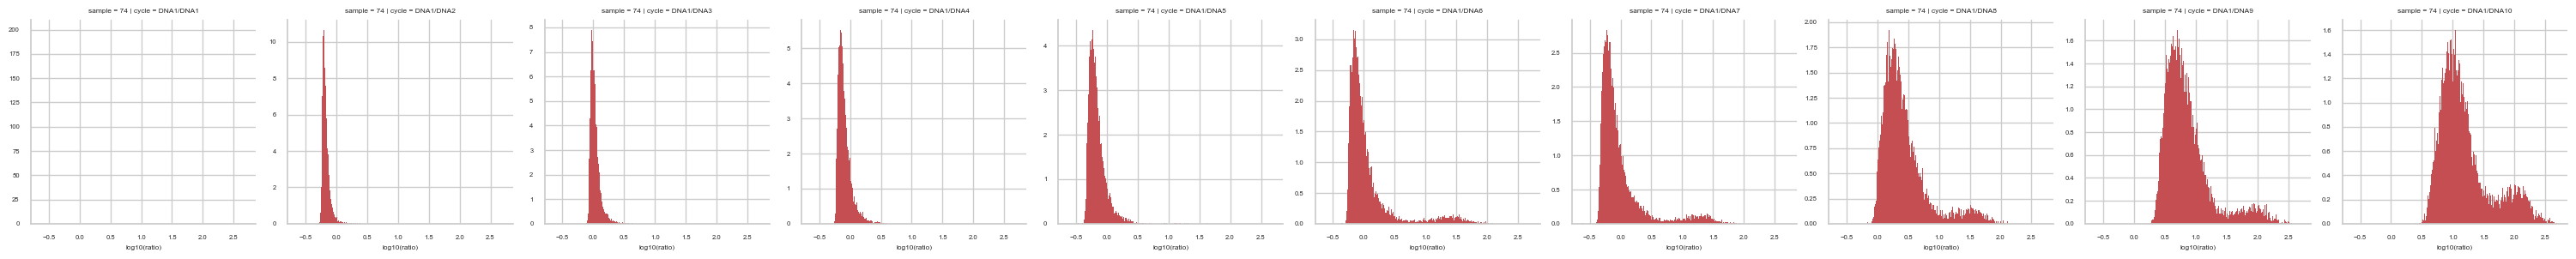

In [5]:
# plot log(ratio) histograms
dna_cycles = natsorted([i for i in dna_data.columns if 'DNA' in i])

ratios = pd.DataFrame(
    [np.log10(
        (dna_data['DNA1'] + 0.00001) /
        (dna_data[i] + 0.00001)) for i in dna_cycles]).T

list1 = [i for i in ratios.columns if i.startswith('Unnamed')]
list2 = [f'DNA1/{i}' for i in [j for j in dna_cycles[1:]]]
ratio_columns = dict(zip(list1, list2))
ratio_columns['DNA1'] = 'DNA1/DNA1'
ratios.rename(columns=ratio_columns, inplace=True)

# append samples, X and Y centroids to ratio table
ratios['sample'] = dna_data['Sample']
ratios['X_centroid'] = core_data['X_centroid']
ratios['Y_centroid'] = core_data['Y_centroid']

ratios_melt = (
    ratios
    .reset_index()
    .melt(id_vars=['sample', 'index', 'X_centroid', 'Y_centroid'], var_name='cycle',
          value_name='log10(ratio)')
    )

ratios_melt['sample'] = pd.Categorical(
    ratios_melt['sample'], ordered=True,
    categories=natsorted(
        ratios_melt['sample'].unique()))

ratios_melt['cycle'] = pd.Categorical(
    ratios_melt['cycle'], ordered=True,
    categories=natsorted(
        ratios_melt['cycle'].unique()))

ratios_melt = (
    ratios_melt.sort_values(['sample', 'cycle', 'index'])
    )

sns.set(font_scale=0.5)
sns.set_style('whitegrid')

g = sns.FacetGrid(
    ratios_melt, row='sample',
    col='cycle', sharey=False
    )

g = g.map(
    plt.hist, 'log10(ratio)', color='r', histtype='stepfilled',
    ec='none', range=None, bins=200, density=True
    )

plt.savefig(
    os.path.join(save_dir, 'cycle_correlation_logRatios.pdf')
    )
plt.show()
plt.close('all')

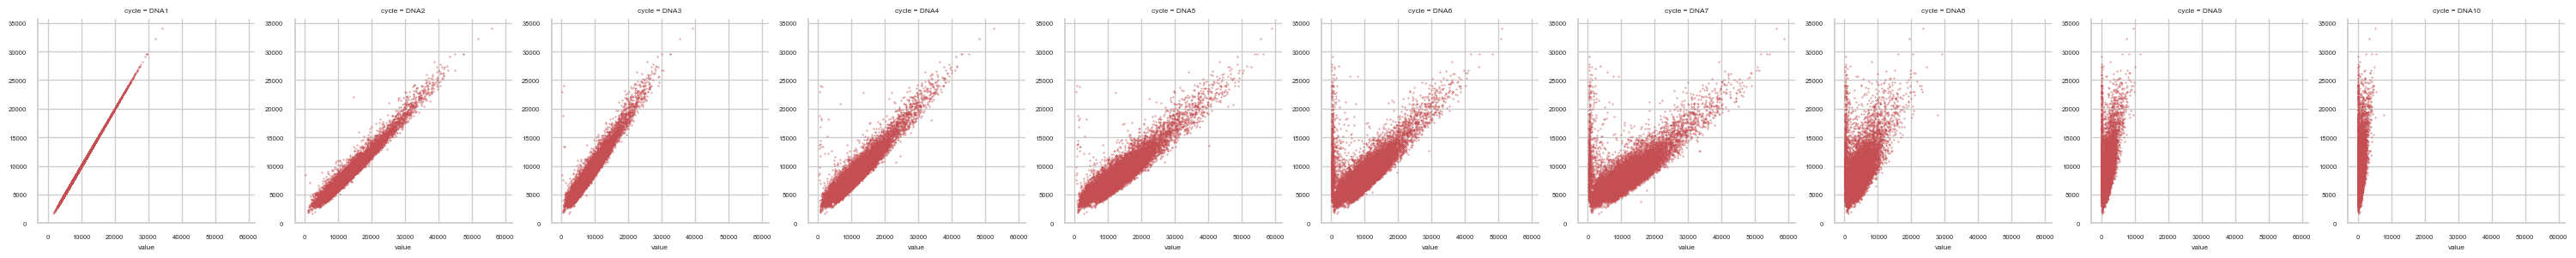

In [6]:
# plot cycle scatter points BEFORE removing dropout
facet_per_cycle_melt = (
    dna_data
    .sample(frac=1.0)
    .reset_index()
    .melt(id_vars=['Sample', 'index'], var_name='cycle',
          )
    )

facet_per_cycle_melt['Sample'] = pd.Categorical(
    facet_per_cycle_melt['Sample'], ordered=True,
    categories=natsorted(
        facet_per_cycle_melt['Sample'].unique()))

facet_per_cycle_melt['cycle'] = pd.Categorical(
    facet_per_cycle_melt['cycle'], ordered=True,
    categories=natsorted(
        facet_per_cycle_melt['cycle'].unique()))

facet_per_cycle_melt = (
    facet_per_cycle_melt.sort_values(['Sample', 'cycle', 'index'])
    )

# plot dna intensity correlation per cycle
g = sns.FacetGrid(
    facet_per_cycle_melt, col='cycle', col_wrap=10,
    sharex=True, sharey=False, aspect = 1.0
    )

g.map(
    lambda y, color: plt.scatter(
        y, facet_per_cycle_melt['value'].loc[
            facet_per_cycle_melt['cycle']
            == 'DNA1'],
        s=0.1, alpha=1.0, linewidth=None,
        marker='o', c='r'), 'value')

plt.savefig(
    os.path.join(
        save_dir, 'cycle_correlation_before.pdf')
        )
plt.show()
plt.close('all')

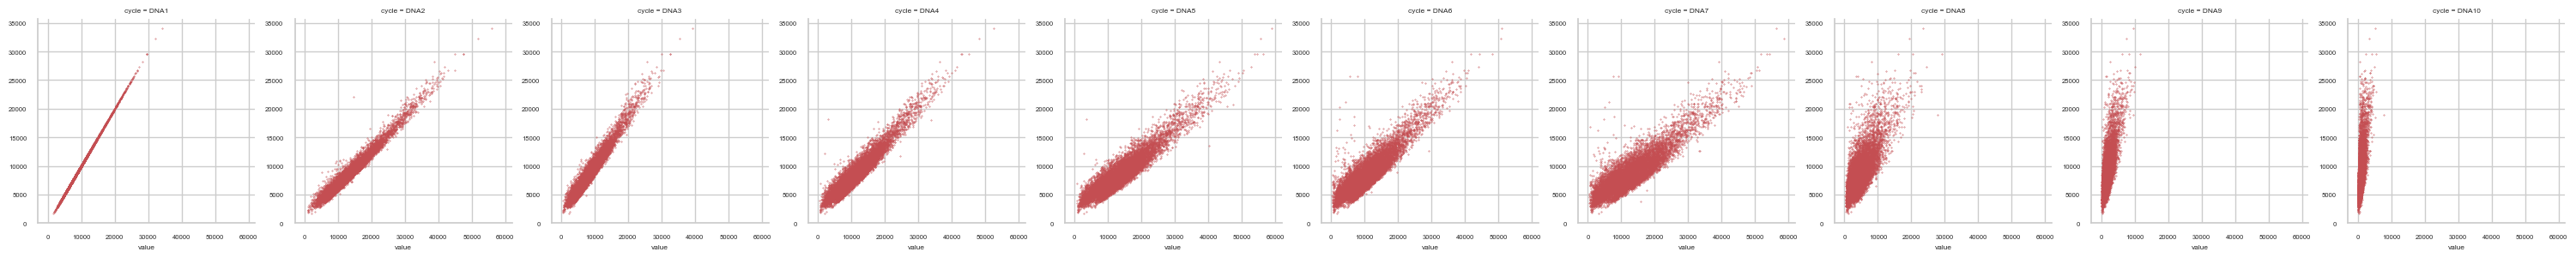

In [7]:
# plot cycle scatter points AFTER removing dropout
dna_filtered = dna_data.copy()
dna_filtered['ratio'] = ratios['DNA1/DNA10']

# select and apply ratio cutoff value
gate = 1.65
dna_filtered = dna_filtered[dna_filtered['ratio'] < gate]
dna_filtered.drop(columns='ratio', inplace=True)

facet_per_cycle_melt = (
    dna_filtered
    .sample(frac=1.0)
    .reset_index()
    .melt(id_vars=['Sample', 'index'], var_name='cycle',
          )
    )

facet_per_cycle_melt['Sample'] = pd.Categorical(
    facet_per_cycle_melt['Sample'], ordered=True,
    categories=natsorted(
        facet_per_cycle_melt['Sample'].unique()))

facet_per_cycle_melt['cycle'] = pd.Categorical(
    facet_per_cycle_melt['cycle'], ordered=True,
    categories=natsorted(
        facet_per_cycle_melt['cycle'].unique()))

facet_per_cycle_melt = (
    facet_per_cycle_melt.sort_values(['Sample', 'cycle', 'index'])
    )

g = sns.FacetGrid(
    facet_per_cycle_melt, col='cycle', col_wrap=10,
    sharex=True, sharey=False
    )

g.map(
    lambda y, color: plt.scatter(
        y, facet_per_cycle_melt['value'].loc[
            facet_per_cycle_melt['cycle']
            == 'DNA1'],
        s=0.1, alpha=1.0, linewidth=None,
        marker='o', c='r'), 'value')

plt.savefig(os.path.join(save_dir, 'cycle_correlation_after.pdf'))
plt.show()
plt.close('all')

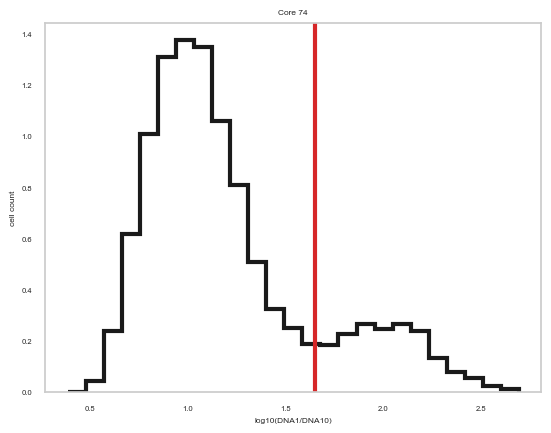

In [8]:
plt.hist(ratios['DNA1/DNA10'], bins=25, color='k', density=True, histtype='step', lw=3.0)
plt.grid(False)
plt.axvline(gate, c='tab:red', lw=3.0)
plt.title(f'Core {core}')
plt.xlabel('log10(DNA1/DNA10)')
plt.ylabel('cell count')
plt.savefig(os.path.join(save_dir, 'gated_hist.pdf'))
plt.show()
plt.close('all')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


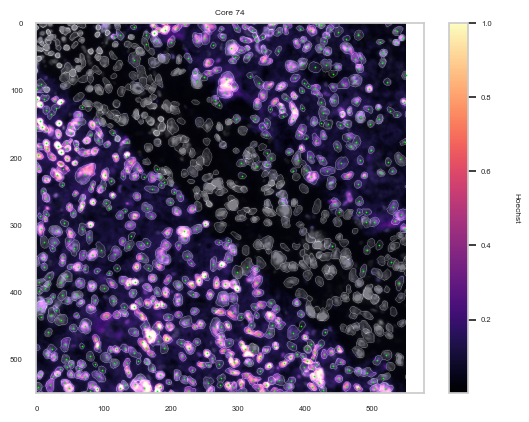

In [9]:
# crop
ymin = 1000
ymax = 1550
xmin = 550
xmax = 1100

# read first DNA image
first = imread(
    '/Volumes/My Book/cylinter_input/emit22_full/' +
    f'tif/{core}.ome.tif', key=0
    )
first_crop = first[ymin:ymax, xmin:xmax]

# read last DNA image 
last = imread(
    '/Volumes/My Book/cylinter_input/emit22_full/' +
    f'tif/{core}.ome.tif', key=36
    )
last_crop = last[ymin:ymax, xmin:xmax]

# read segmentation outlines for target core sample and crop ROI
seg = imread(
    '/Volumes/My Book/cylinter_input/emit22_full/' +
    f'seg/{core}.ome.tif', key=0
    )
seg_crop = seg[ymin:ymax, xmin:xmax]

blank = np.zeros((first_crop.shape[0], first_crop.shape[1]))
blank = gray2rgb(blank)

first_crop = img_as_float(first_crop)
first_crop = (first_crop - np.min(first_crop))/np.ptp(first_crop)
first_crop = np.clip(first_crop, 0, 0.4)
first_crop = (first_crop - np.min(first_crop))/np.ptp(first_crop)
first_crop = gray2rgb(first_crop)
first_crop *= (0.5, 0.5, 0.5)  # bop blue: (0.125, 0.678, 0.973)
blank += first_crop

last_crop = img_as_float(last_crop)
last_crop = (last_crop - np.min(last_crop))/np.ptp(last_crop)
last_crop = np.clip(last_crop, 0, 0.5)
last_crop = (last_crop - np.min(last_crop))/np.ptp(last_crop)

last_crop = plt.cm.magma(last_crop) # converts to RGBA automatically
last_crop = last_crop[:, :, 0:3]  # drop alpha dimension
# last_crop = gray2rgb(last_crop)
# last_crop *= (0.84, 0.153, 0.157)  # bop orange: (0.973, 0.678, 0.125)
blank += last_crop

seg_crop = img_as_float(seg_crop)
seg_crop_rgb = gray2rgb(seg_crop)
seg_crop_rgb *= 0.5
blank += seg_crop_rgb

plt.imshow(blank, cmap='magma')
plt.grid(False)
cbar = plt.colorbar()
cbar.set_alpha(1.0)
cbar.set_label('Hoechst', labelpad=20, rotation=270)
cbar.draw_all()

# plt.title(f'Core {core}')
# plt.savefig(os.path.join(save_dir, 'correlation.png'), dpi=1000)
# plt.savefig(os.path.join(save_dir, 'correlation.pdf'))
# plt.show()
# plt.close('all')

# blank = np.zeros((first_crop.shape[0], first_crop.shape[1]))
# blank = gray2rgb(blank)

# plt.imshow(blank)
# plt.grid(False)

# overlay cell centroids
ratios_crop = ratios[['Y_centroid', 'X_centroid', 'DNA1/DNA10']][
    (ratios['X_centroid'].between(xmin, xmax, inclusive='both')) &
    (ratios['Y_centroid'].between(ymin, ymax, inclusive='both'))
    ]
ratios_crop['X_centroid'] = ratios_crop['X_centroid']-xmin
ratios_crop['Y_centroid'] = ratios_crop['Y_centroid']-ymin

gated_data = ratios_crop[ratios_crop['DNA1/DNA10'] < gate]

plt.scatter(
    gated_data['X_centroid'],
    gated_data['Y_centroid'],
    s=1.5, lw=0.0, color='lime'
    )
plt.title(f'Core {core}')
plt.savefig(os.path.join(save_dir, 'gated_data.png'), dpi=1000)
plt.savefig(os.path.join(save_dir, 'gated_data.pdf'))
plt.show()
plt.close('all')